In [1]:
import os
os.environ['SM_FRAMEWORK'] = 'tf.keras'

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt

2023-10-17 01:07:37.332976: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# resizing all the images
IMAGE_SIZE = (100,100)
path = '/Users/sahreenhaider/Downloads/New_Data_CoV2'
data = []

In [4]:
def data_loader():
  main_folder = 0
  folder = 0
  sub_folder = 0
  c = 0
  try:
    for folder in os.listdir(path):
      try:
        sub_path=path+"/"+folder
        for folder2 in os.listdir(sub_path):
          try:
            sub_path2=sub_path+"/"+folder2
            for img in os.listdir(sub_path2):
              image_path=sub_path2+"/"+img
              img_arr=cv2.imread(image_path)
              img_arr=cv2.resize(img_arr,IMAGE_SIZE)
              data.append(img_arr)
          except Exception as E:
            c+=1
      except Exception as E:
        sub_folder += 1
  except Exception as E:
    main_folder += 1   

In [5]:
data_loader()

In [6]:
# converting the data list consisting of arrays into an array
X = np.array(data)

In [7]:
# shape of X
X.shape

(4171, 100, 100, 3)

In [8]:
# normalizing the input
x = X/255

In [9]:
# using datagen to agument the existing input data to make the prediction labels
datagen = ImageDataGenerator(rescale = 1/255)
dataset = datagen.flow_from_directory(path,
                                    target_size = IMAGE_SIZE,
                                    batch_size = 32,
                                    class_mode = 'sparse')

Found 4171 images belonging to 3 classes.


In [10]:
# classes of predict labels
dataset.class_indices

{'Covid': 0, 'Healthy': 1, 'Others': 2}

In [11]:
y = dataset.classes

In [12]:
y.shape

(4171,)

In [13]:
x.shape

(4171, 100, 100, 3)

In [14]:
# splitting the data into train, validation, test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.1)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2)

In [15]:
x_train.shape, y_train.shape

((3002, 100, 100, 3), (3002,))

In [16]:
x_val.shape, y_val.shape

((751, 100, 100, 3), (751,))

In [17]:
x_test.shape, y_test.shape

((418, 100, 100, 3), (418,))

In [18]:
x_train[0].shape

(100, 100, 3)

In [19]:
from tensorflow._api.v2.nn import dropout
model = tf.keras.Sequential()

# convoltuion layer
model.add(tf.keras.layers.Conv2D(32, (3,3), activation = tf.nn.relu, input_shape = x_train[0].shape))
# pooling layer
model.add(tf.keras.layers.MaxPool2D(2,2))
model.add(tf.keras.layers.BatchNormalization())


# convolution layer
model.add(tf.keras.layers.Conv2D(32, (3,3), activation = tf.nn.relu))
# pooling layer
model.add(tf.keras.layers.MaxPool2D(2,2))
model.add(tf.keras.layers.BatchNormalization())

# convolution layer
model.add(tf.keras.layers.Conv2D(64, (3,3), activation = tf.nn.relu))
# pooling layer
model.add(tf.keras.layers.MaxPool2D(2,2))
model.add(tf.keras.layers.BatchNormalization())

# convolution layer
model.add(tf.keras.layers.Conv2D(64, (3,3), activation = tf.nn.relu))
# pooling layer
model.add(tf.keras.layers.MaxPool2D(2,2))
model.add(tf.keras.layers.BatchNormalization())

# input layer
model.add(tf.keras.layers.Flatten())


# output layer
model.add(tf.keras.layers.Dense(3, activation = tf.nn.softmax))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 98, 98, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 49, 49, 32)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 49, 49, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 47, 47, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 23, 23, 32)       0         
 2D)                                                             
                                                        

In [20]:
# compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [22]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, start_from_epoch = 7, patience=15)

In [23]:
record = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=50, callbacks=[early_stop], shuffle=True)

Epoch 1/50
94/94 [==============================] - 42s 407ms/step - loss: 0.9698 - accuracy: 0.5736 - val_loss: 1.1079 - val_accuracy: 0.2983
Epoch 2/50
94/94 [==============================] - 48s 510ms/step - loss: 0.6622 - accuracy: 0.7169 - val_loss: 1.1081 - val_accuracy: 0.2996
Epoch 3/50
94/94 [==============================] - 37s 396ms/step - loss: 0.5218 - accuracy: 0.7928 - val_loss: 1.2864 - val_accuracy: 0.3036
Epoch 4/50
94/94 [==============================] - 42s 446ms/step - loss: 0.3805 - accuracy: 0.8671 - val_loss: 1.3206 - val_accuracy: 0.3835
Epoch 5/50
94/94 [==============================] - 39s 410ms/step - loss: 0.2635 - accuracy: 0.9174 - val_loss: 0.7714 - val_accuracy: 0.6711
Epoch 6/50
94/94 [==============================] - 41s 437ms/step - loss: 0.2187 - accuracy: 0.9260 - val_loss: 0.8007 - val_accuracy: 0.6977
Epoch 7/50
94/94 [==============================] - 38s 403ms/step - loss: 0.1379 - accuracy: 0.9637 - val_loss: 1.3466 - val_accuracy: 0.5686

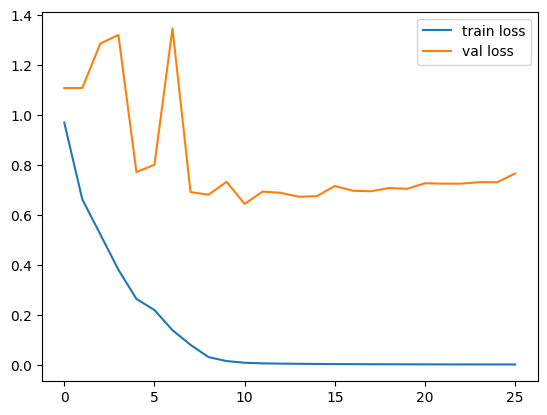

In [24]:
plt.plot(record.history['loss'], label = 'train loss')
plt.plot(record.history['val_loss'], label = 'val loss')
plt.legend()

plt.savefig('loss_graph.png')
plt.show()

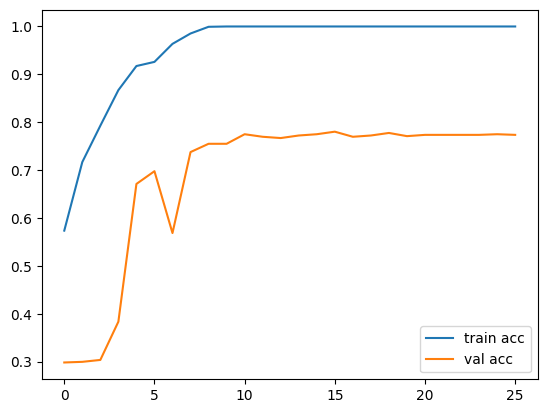

In [25]:
# accuracy over epochs
plt.plot(record.history['accuracy'], label = 'train acc')
plt.plot(record.history['val_accuracy'], label = 'val acc')
plt.legend()
plt.savefig('acc-graph.png')
plt.show()

In [26]:
y_val_pred = model.predict(x_val)
y_val_pred = np.argmax(y_val_pred, axis=1)
print(classification_report(y_val_pred, y_val))

24/24 [==============================] - 4s 127ms/step
              precision    recall  f1-score   support

           0       0.91      0.80      0.85       454
           1       0.55      0.68      0.61       102
           2       0.66      0.75      0.70       195

    accuracy                           0.77       751
   macro avg       0.70      0.74      0.72       751
weighted avg       0.80      0.77      0.78       751



In [27]:
confusion_matrix(y_val_pred, y_val)

array([[365,  33,  56],
       [ 12,  69,  21],
       [ 24,  24, 147]])

In [28]:
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis = 1)

14/14 [==============================] - 2s 100ms/step


In [29]:
accuracy_score(y_pred, y_test)

0.7655502392344498

In [30]:
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.91      0.81      0.85       240
           1       0.55      0.69      0.62        52
           2       0.65      0.71      0.68       126

    accuracy                           0.77       418
   macro avg       0.70      0.74      0.72       418
weighted avg       0.78      0.77      0.77       418



In [31]:
confusion_matrix(y_pred, y_test)

array([[194,   9,  37],
       [  4,  36,  12],
       [ 16,  20,  90]])

In [ ]:
model.to_json('/Users/sahreenhaider/Documents/Covid_detection_model/model.json')

In [33]:
model.save('/Users/sahreenhaider/Documents/Covid_detection_model/model.h5')